In [3]:
%matplotlib inline
from SALib.sample import saltelli
# from wolf_sheep.model import WolfSheep
# from wolf_sheep.agents import Wolf, Sheep
from mesa.batchrunner import BatchRunner
from SALib.analyze import sobol
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from model import GeoModel
%load_ext autoreload
%autoreload 2

# Parameters

Num_buildings [50,100,5]
Num_destinations [2,10,1]
Trace_strength [10,100,10] //Same as trace length
Vision_angle [7.5,90,7.5]
Vision_samples [3,15,2]

# OFAT

In [15]:
# We define our variables and bounds
problem = {
    'num_vars': 5,
    'names': ['num_buildings', 'num_destinations', 'trace_strength', 'vision_angle', 'vision_samples'],
    'bounds': [[50,100,11], [2,10,9], [10,100,10], [7.5,90,12], [3,15,7]]
    # 'bounds': [[50,100,2], [2,10,2], [10,100,2], [7.5,90,2], [3,15,2]]
}

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 30
max_steps = 170
# distinct_samples = 30 

# Set the outputs
model_reporters = {'Avg_raster_value': lambda m: m.avg_raster_value}

data = pd.DataFrame()

for i, var in enumerate(problem['names']):
    # Get the bounds for this variable and get <distinct_samples> samples within this space (uniform)
    samples = np.linspace(*problem['bounds'][i], dtype=int)
    
    # # Keep in mind that wolf_gain_from_food should be integers. You will have to change
    # # your code to acommodate for this or sample in such a way that you only get integers.
    if var == 'vision_angle':
        samples = np.linspace(*problem['bounds'][i])
    
    batch = BatchRunner(GeoModel, 
                        max_steps=max_steps,
                        iterations=replicates,
                        variable_parameters={var: samples},
                        model_reporters=model_reporters,
                        display_progress=True)
    
    batch.run_all()
    
    data = pd.concat([data, batch.get_model_vars_dataframe()])

C:\Users\mylen\AppData\Local\Temp\ipykernel_46724\2817027993.py:28: DeprecationWarning: BatchRunner class has been replaced by batch_run function. Please see documentation.
  batch = BatchRunner(GeoModel,
4it [00:19,  4.88s/it]
C:\Users\mylen\AppData\Local\Temp\ipykernel_46724\2817027993.py:28: DeprecationWarning: BatchRunner class has been replaced by batch_run function. Please see documentation.
  batch = BatchRunner(GeoModel,
4it [00:20,  5.17s/it]
C:\Users\mylen\AppData\Local\Temp\ipykernel_46724\2817027993.py:28: DeprecationWarning: BatchRunner class has been replaced by batch_run function. Please see documentation.
  batch = BatchRunner(GeoModel,
4it [00:14,  3.62s/it]
C:\Users\mylen\AppData\Local\Temp\ipykernel_46724\2817027993.py:28: DeprecationWarning: BatchRunner class has been replaced by batch_run function. Please see documentation.
  batch = BatchRunner(GeoModel,
0it [00:00, ?it/s]


TypeError: GeoModel.__init__() got an unexpected keyword argument 'vision_angle'

In [21]:
data

,num_buildings,Run,Avg_raster_value,num_destinations,trace_strength
0,50.0,0,40.746589,NaN,NaN
1,50.0,1,40.452055,NaN,NaN
2,100.0,2,39.704673,NaN,NaN
3,100.0,3,40.145794,NaN,NaN
0,NaN,0,40.313910,2.0,NaN
1,NaN,1,40.574861,2.0,NaN
2,NaN,2,40.104779,10.0,NaN
3,NaN,3,39.981550,10.0,NaN
0,NaN,0,8.443820,NaN,10.0
1,NaN,1,8.452652,NaN,10.0


In [17]:
data.to_csv('OFAT_data.csv')

KeyError: 'vision_angle'

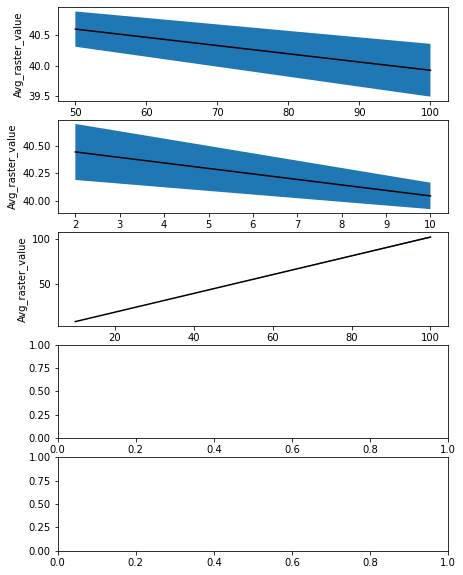

In [20]:
def plot_param_var_conf(ax, df, var, param, i):
    """
    Helper function for plot_all_vars. Plots the individual parameter vs
    variables passed.

    Args:
        ax: the axis to plot to
        df: dataframe that holds the data to be plotted
        var: variables to be taken from the dataframe
        param: which output variable to plot
    """
    x = df.groupby(var).mean().reset_index()[var]
    y = df.groupby(var).mean()[param]

    replicates = df.groupby(var)[param].count()
    err = (1.96 * df.groupby(var)[param].std()) / np.sqrt(replicates)

    ax.plot(x, y, c='k')
    ax.fill_between(x, y - err, y + err)

    ax.set_xlabel(var)
    ax.set_ylabel(param)

def plot_all_vars(df, param):
    """
    Plots the parameters passed vs each of the output variables.

    Args:
        df: dataframe that holds all data
        param: the parameter to be plotted
    """

    f, axs = plt.subplots(5, figsize=(7, 10))
    
    for i, var in enumerate(problem['names']):
        df_temp = df[~df[var].isna()]
        plot_param_var_conf(axs[i], df_temp, var, param, i)


plot_all_vars(data, 'Avg_raster_value')
plt.savefig('plots/OFAT_plot.png')

# Sobol

In [ ]:
# We define our variables and bounds
problem = {
    'num_vars': 5,
    'names': ['num_buildings', 'num_destinations', 'trace_strength', 'vision_angle', 'vision_samples'],
    'bounds': [[50,100], [2,10], [10,100], [7.5,90], [3,15]]
    # 'bounds': [[50,100,2], [2,10,2], [10,100,2], [7.5,90,2], [3,15,2]]
}

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 10
max_steps = 100
distinct_samples = 10

# We get all our samples here
param_values = saltelli.sample(problem, distinct_samples)

# READ NOTE BELOW CODE
batch = BatchRunner(GeoModel, 
                    max_steps=max_steps,
                    variable_parameters={name:[] for name in problem['names']},
                    model_reporters=model_reporters)

count = 0
data = pd.DataFrame(index=range(replicates*len(param_values)), 
                                columns=['num_buildings', 'num_destinations', 'trace_strength', 'vision_angle', 'vision_samples'])
data['Run'], data['Avg_raster_value'] = None, None

for i in range(replicates):
    for vals in param_values: 
        # Change parameters that should be integers
        vals = list(vals)
        vals[0] = int(vals[0])
        vals[1] = int(vals[1])
        vals[2] = int(vals[2])
        vals[4] = int(vals[4])
        # Transform to dict with parameter names and their values
        variable_parameters = {}
        for name, val in zip(problem['names'], vals):
            variable_parameters[name] = val

        batch.run_iteration(variable_parameters, tuple(vals), count)
        iteration_data = batch.get_model_vars_dataframe().iloc[count]
        iteration_data['Run'] = count # Don't know what causes this, but iteration number is not correctly filled
        data.iloc[count, 0:5] = vals
        data.iloc[count, 5:7] = iteration_data
        count += 1

        clear_output()
        print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')

In [ ]:
print(data)

From here I haven't altered the code yet

In [ ]:
Si_sheep = sobol.analyze(problem, data['Sheep'].values, print_to_console=True)
Si_wolves = sobol.analyze(problem, data['Wolves'].values, print_to_console=True)

In [ ]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

In [ ]:
for Si in (Si_sheep, Si_wolves):
    # First order
    plot_index(Si, problem['names'], '1', 'First order sensitivity')
    plt.show()

    # # Second order
    # plot_index(Si, problem['names'], '2', 'Second order sensitivity')
    # plt.show()

    # Total order
    plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
    plt.show()